In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import glob
import json
import os
from pprint import pprint

In [2]:
results_base = "experiments/"
results_dir = "qwen06_results"
path = results_base + results_dir

# Get every .json file in every subdir
json_files = glob.glob(os.path.join(path, "**/*.json"), recursive=True)
pprint(json_files)

['experiments/qwen06_results/basic_qwen06b_chunks_identity_normTrue_ip_n14735_20250822_150354/results_basic_qwen06b_chunks_identity_normTrue_ip_n14735_20250822_150354.json',
 'experiments/qwen06_results/basic_qwen06b_contributions_add_abstract_normTrue_ip_n14735_20250825_134553/results_basic_qwen06b_contributions_add_abstract_normTrue_ip_n14735_20250825_134553.json',
 'experiments/qwen06_results/basic_qwen06b_contributions_add_prev_3_normTrue_ip_n14735_20250825_135036/results_basic_qwen06b_contributions_add_prev_3_normTrue_ip_n14735_20250825_135036.json',
 'experiments/qwen06_results/basic_qwen06b_chunks_add_prev_3_normTrue_ip_n14735_20250825_132036/results_basic_qwen06b_chunks_add_prev_3_normTrue_ip_n14735_20250825_132036.json',
 'experiments/qwen06_results/basic_qwen06b_contributions_identity_normTrue_ip_n14735_20250822_145301/results_basic_qwen06b_contributions_identity_normTrue_ip_n14735_20250822_145301.json',
 'experiments/qwen06_results/basic_qwen06b_chunks_add_title_normTrue_ip_

In [3]:
def path_to_label(path):
    filename = os.path.basename(path)
    pieces = filename.split("_")
    model = pieces[2]
    document_rep = pieces[3]
    query_expansion = ""
    if "title" in filename:
        query_expansion = "title"
    elif "abstract" in filename:
        query_expansion = "abstract"
    elif "prev_3" in filename:
        query_expansion = "prev_3"
    elif "prev_5" in filename:
        query_expansion = "prev_5"
    elif "prev_7" in filename:
        query_expansion = "prev_7"

    # Filter out empty strings before joining
    parts = [model, document_rep, query_expansion]
    return "+".join([part for part in parts if part and not part in ["basic"]])


names = [path_to_label(filename) for filename in json_files]
for name in sorted(names):
    print(name)

qwen06b+chunks
qwen06b+chunks+abstract
qwen06b+chunks+prev_3
qwen06b+chunks+prev_5
qwen06b+chunks+prev_7
qwen06b+chunks+title
qwen06b+contributions
qwen06b+contributions+abstract
qwen06b+contributions+prev_3
qwen06b+contributions+prev_5
qwen06b+contributions+prev_7
qwen06b+contributions+title


In [4]:
# Build data dict
data = dict()
for file in json_files:
    experiment_results = json.load(open(file))
    hitrates = experiment_results["average_hitrate_at_k"]
    label = path_to_label(file)
    data[label] = hitrates

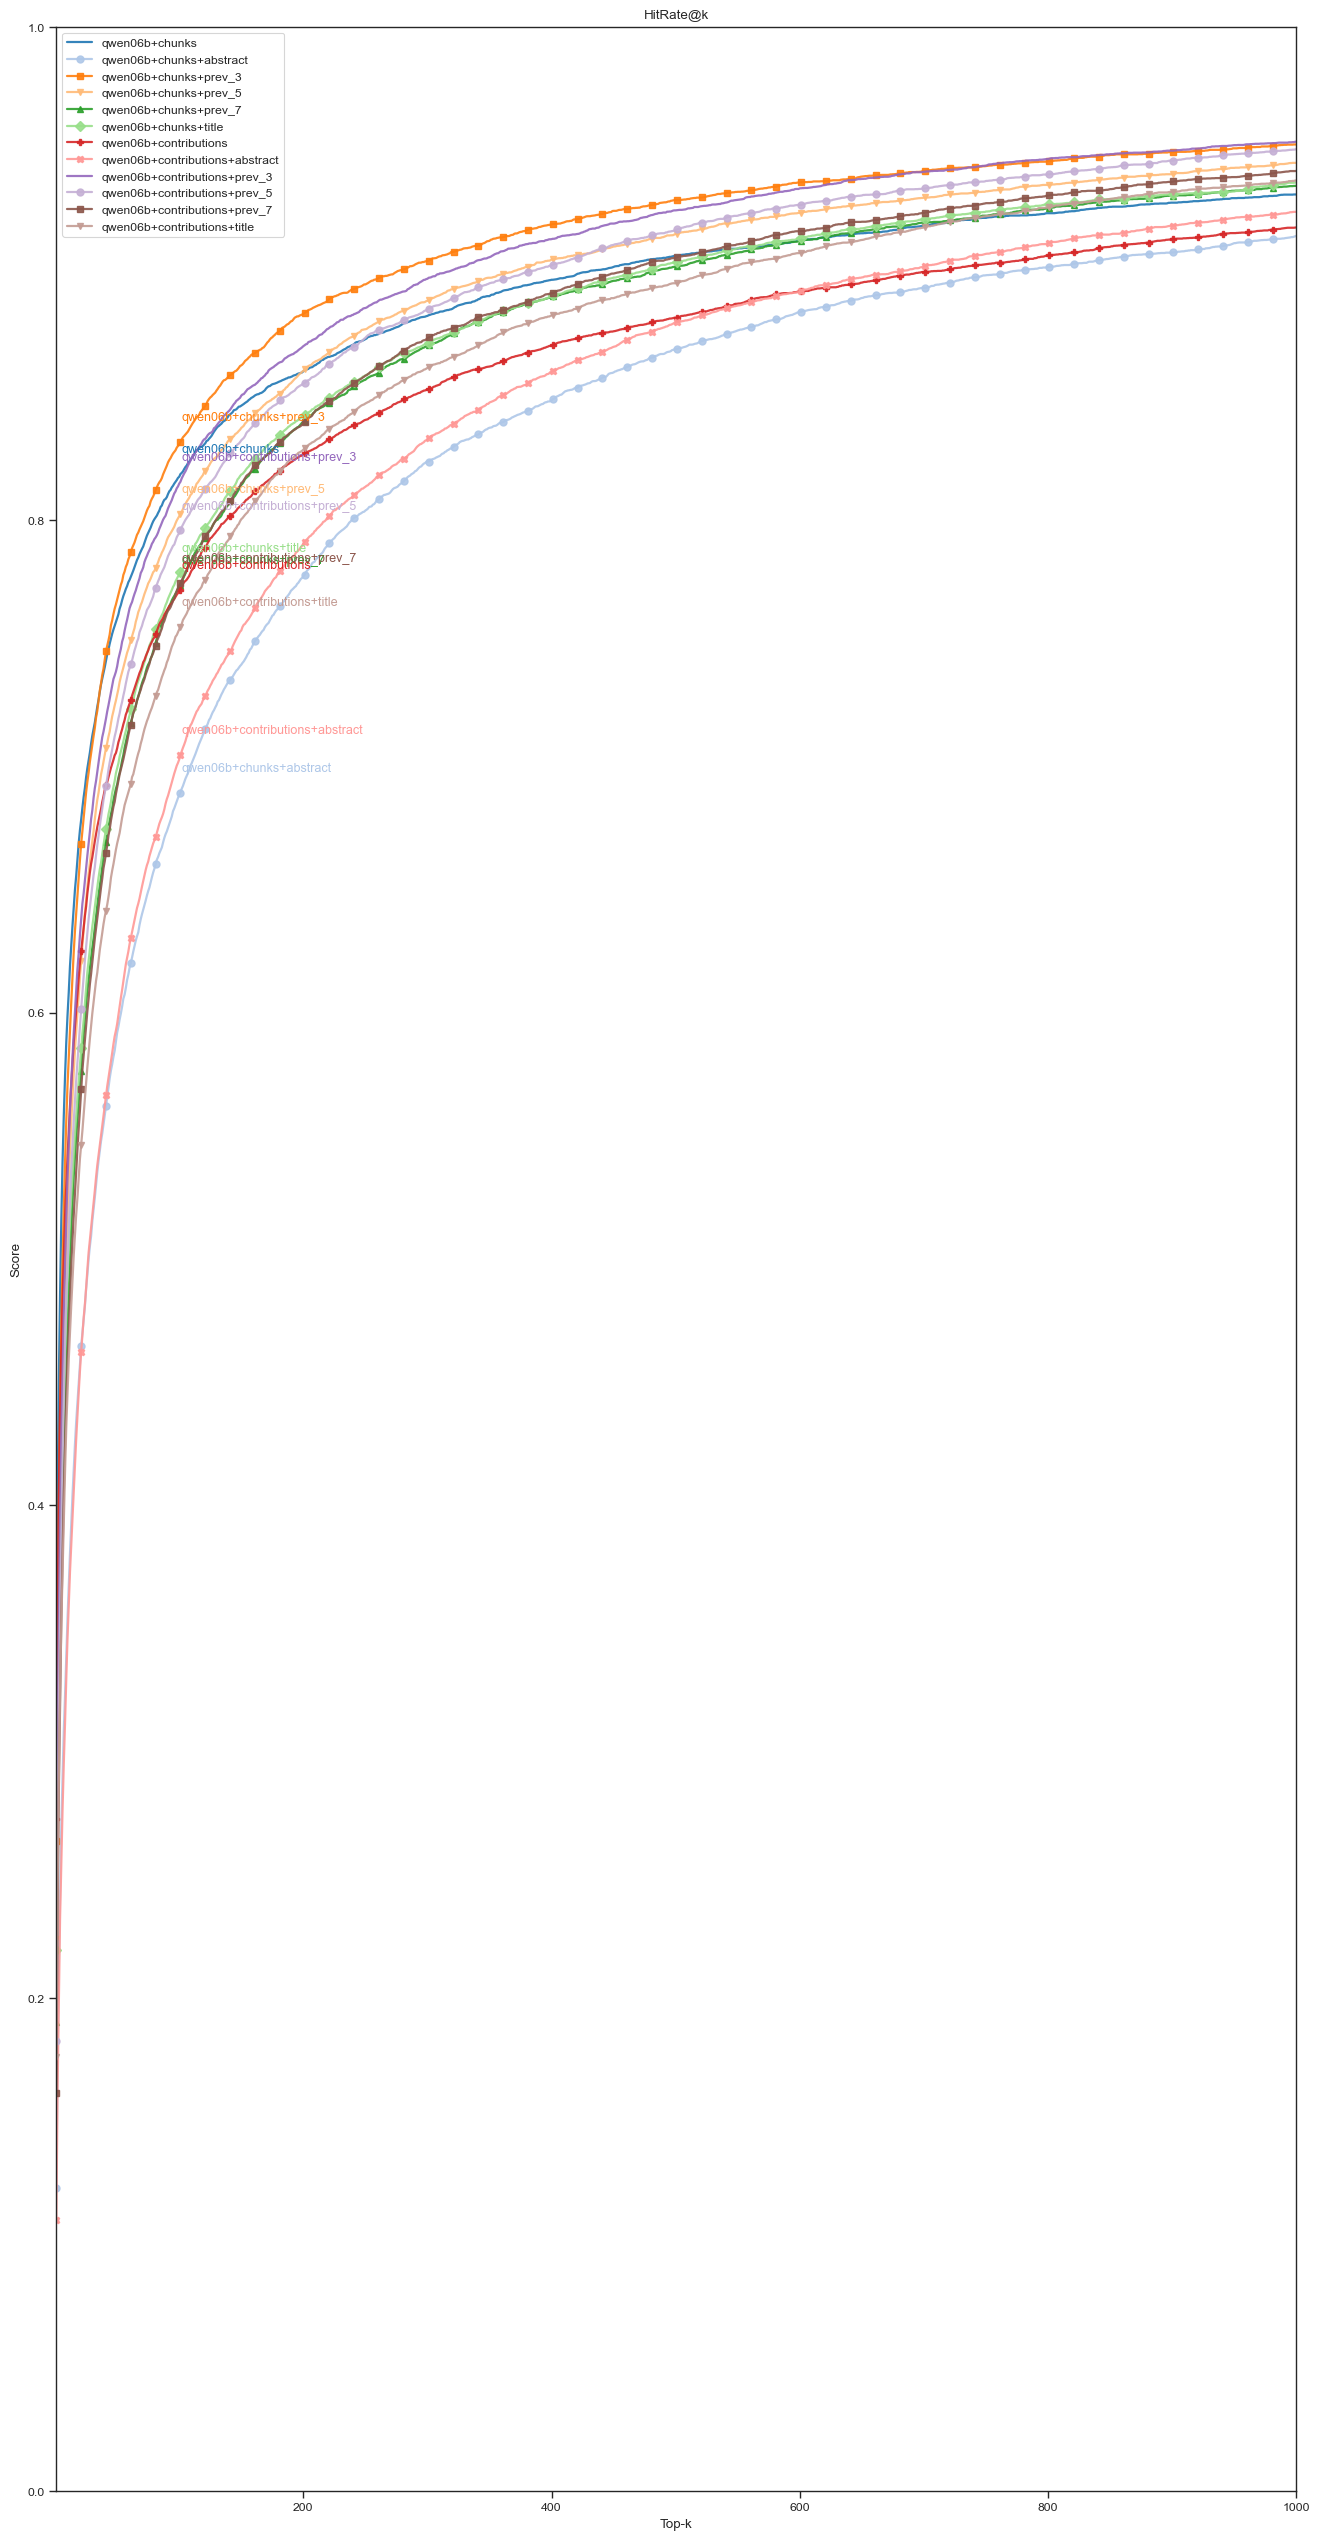

In [5]:
sns.set_theme(style="ticks", context="paper")
palette = sns.color_palette("tab20", n_colors=len(data))
k_values = [k for k in range(1, 1001)]
# linestyles = ["-", "--", "-.", ":"]
markers = [None, "o", "s", "v", "^", "D", "P", "X"]
# Make a plot of the average hit rates (y-axis) and IoU (Jaccard) vs. top-k (x-axis)
plt.figure(figsize=(16, 32))
for i, (label, hitrates) in enumerate(sorted(data.items())):
    color = palette[i % len(palette)]
    # ls = linestyles[i % len(linestyles)]
    marker = markers[i % len(markers)]
    plt.plot(
        k_values,
        hitrates,
        color=color,
        # linestyle=ls,
        linewidth=1.6,
        alpha=0.9,
        label=label,
        marker=marker,
        markevery=20,  # markers only every 20 points to avoid clutter
        markersize=5,
    )
    # direct label at end of line (helps avoid legend lookup)
    plt.text(k_values[100] + 1, hitrates[100] + 0.01, label, color=color, va="center", fontsize=9)

plt.xlim(1, k_values[-1])
plt.ylim(0, 1)
plt.xlabel("Top-k")
plt.ylabel("Score")
plt.title("HitRate@k")
plt.grid(True)
plt.legend()
plt.grid()

# Set x-ticks every 100
# plt.gca().xaxis.set_major_locator(MultipleLocator(100))
plt.savefig(f"{results_dir}_k1000.png")
plt.show()
plt.close()

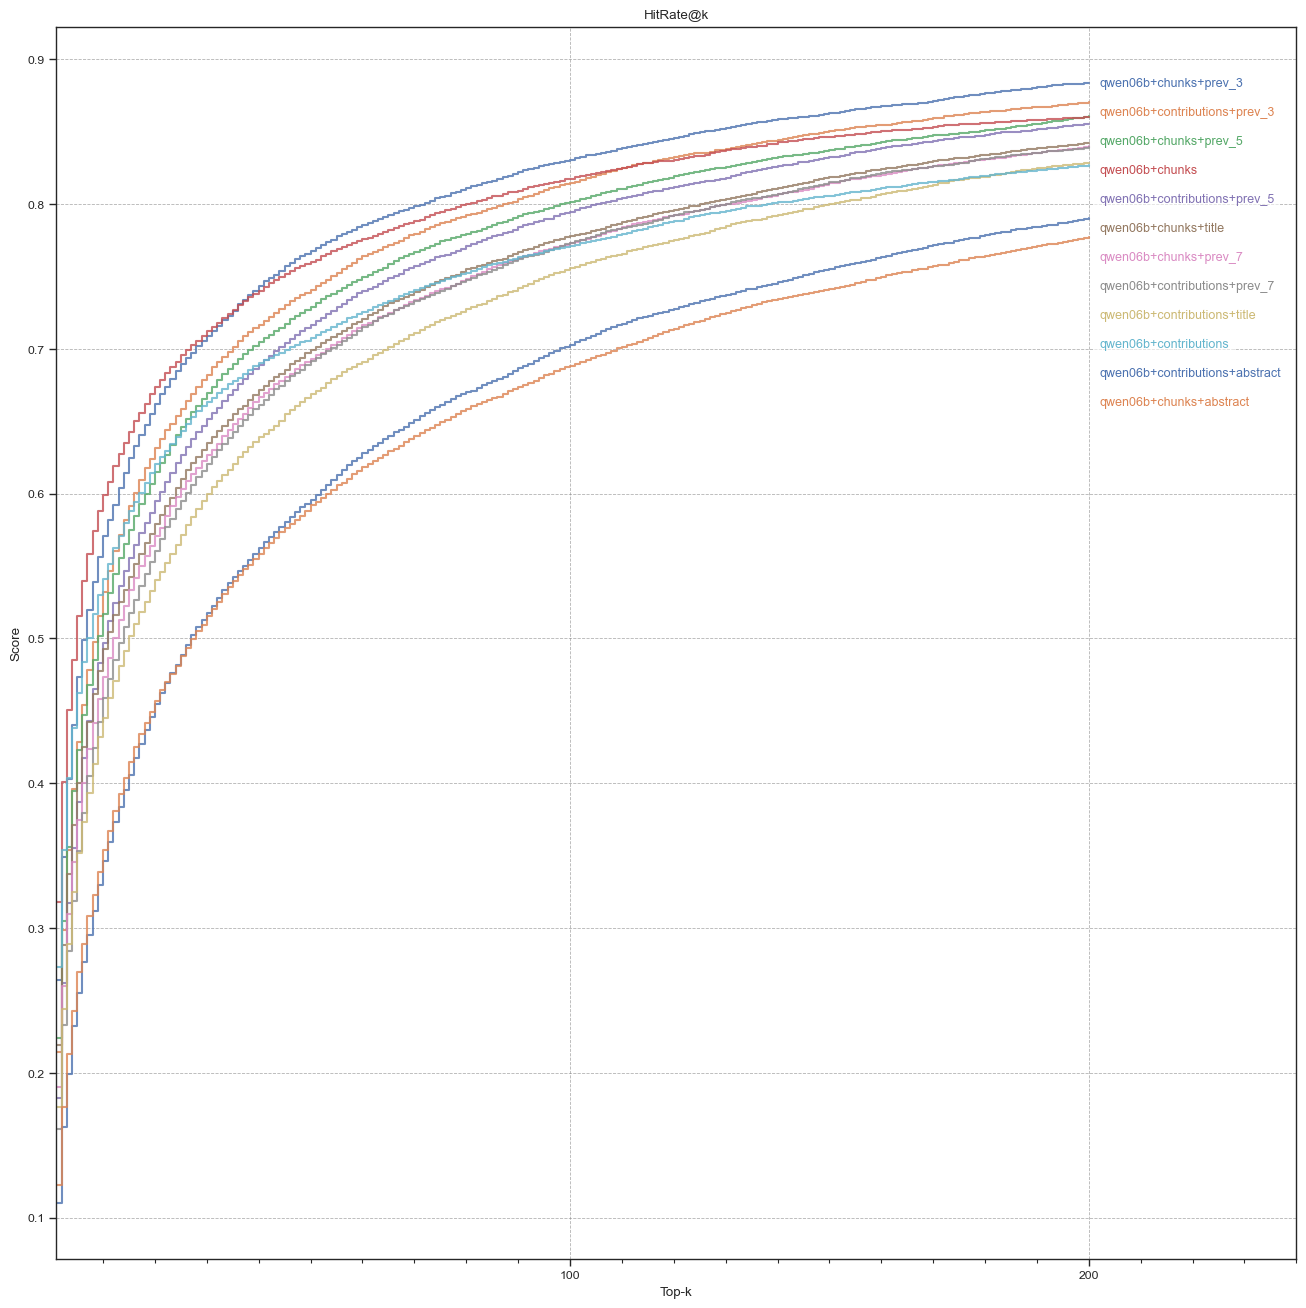

In [6]:
k_values = range(1, 201)
plt.figure(figsize=(16, 16))
ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(which="major", linestyle="--", linewidth=0.6, color="gray", alpha=0.6)
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(10))

lines = []
label_x = 200  # x position to place labels around
min_gap = 0.02  # minimum vertical gap between labels

# collect label positions at k=200
items = []
for label, hitrates in sorted(data.items()):
    hitrates_trunc = hitrates[:200]
    y = hitrates_trunc[-1]  # value at k=200
    items.append({"label": label, "hitrates": hitrates_trunc, "y": float(y)})

# sort by y descending so high values labeled from top down
items.sort(key=lambda x: x["y"], reverse=True)

# greedy spacing pass pushing labels downward to avoid overlap
adjusted_ys = []
for it in items:
    y = it["y"]
    if not adjusted_ys:
        adjusted_ys.append(y)
    else:
        prev = adjusted_ys[-1]
        if prev - y < min_gap:
            y = prev - min_gap
        adjusted_ys.append(y)

# if any labels pushed below 0, clip and do an upward pass to re-space
adjusted_ys = [max(0.0, y) for y in adjusted_ys]
for i in range(len(adjusted_ys) - 2, -1, -1):
    if adjusted_ys[i + 1] - adjusted_ys[i] < min_gap:
        adjusted_ys[i] = adjusted_ys[i + 1] + min_gap
adjusted_ys = [min(1.0, max(0.0, y)) for y in adjusted_ys]

# plot lines and place labels at adjusted positions
for it, y_label in zip(items, adjusted_ys):
    label = it["label"]
    hitrates_trunc = it["hitrates"]
    (line,) = plt.plot(k_values, hitrates_trunc, drawstyle="steps-post", linestyle="-", lw=1.5, alpha=0.8, label=label)
    lines.append((line, label, hitrates_trunc))
    # label slightly to the right of k=200
    plt.text(
        label_x + 2,
        y_label,
        label,
        color=line.get_color(),
        va="center",
        ha="left",
        fontsize=9,
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"),
    )

plt.xlim(1, label_x + 40)  # give room for labels to the right
plt.xlabel("Top-k")
plt.ylabel("Score")
plt.title("HitRate@k")
# Build legend sorted by score at k=200 (descending)
sorted_lines = sorted(lines, key=lambda t: t[2][-1], reverse=True)
handles = [t[0] for t in sorted_lines]
labels = [t[1] for t in sorted_lines]
# plt.legend(handles=handles, labels=labels)
plt.grid(True)
plt.gca().xaxis.set_major_locator(MultipleLocator(100))
plt.gca().xaxis.set_minor_locator(MultipleLocator(10))
plt.savefig(f"{results_dir}_k200.png")
plt.show()
plt.close()

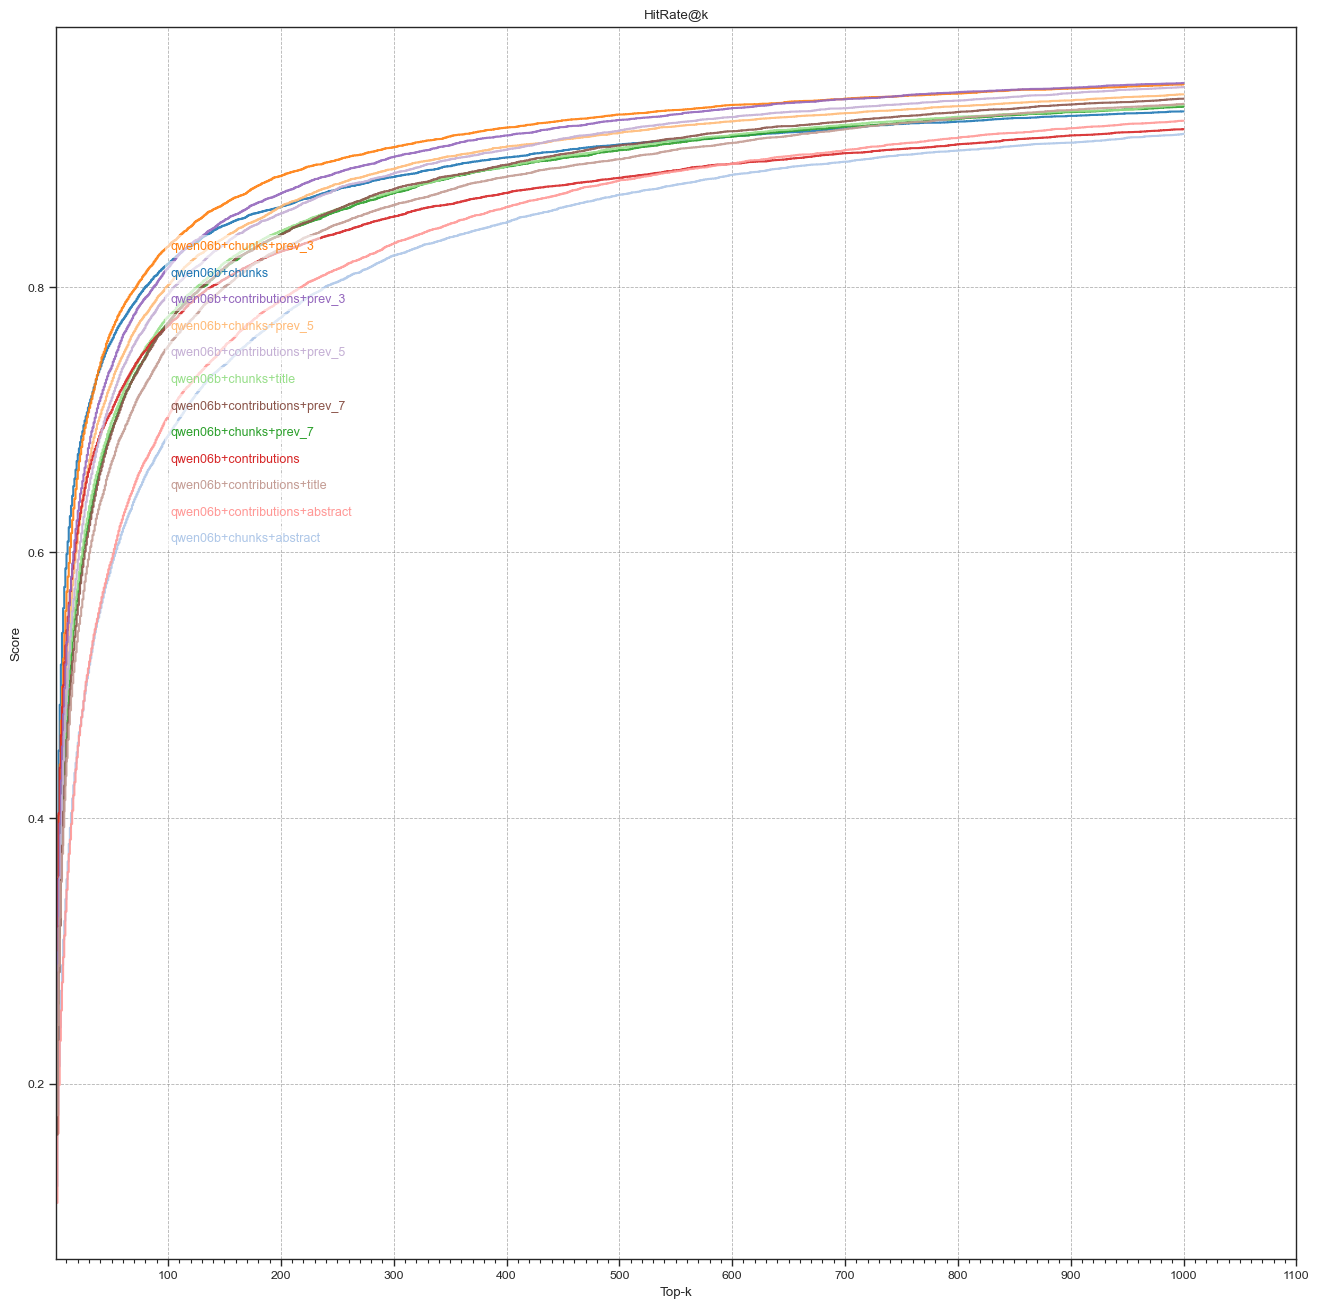

In [21]:
k_values = range(1, 1001)
plt.figure(figsize=(16, 16))
ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(which="major", linestyle="--", linewidth=0.6, color="gray", alpha=0.6)
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(10))

# color palette: tab20 gives up to 20 distinct, good contrast; request at least 12
palette = sns.color_palette("tab20", n_colors=max(12, len(data)))

lines = []
label_k = 100  # anchor k for the grouped labels
label_x = label_k  # x position to place labels around (we'll place slightly right of this)
min_gap = 0.02  # vertical gap between stacked labels

# stable mapping label -> color based on alphabetical sorted order (keeps colors consistent)
sorted_labels = [lbl for lbl, _ in sorted(data.items())]
color_map = {lbl: palette[i % len(palette)] for i, lbl in enumerate(sorted_labels)}

# collect y at k=100 and full hitrates
items = []
for label, hitrates in sorted(data.items()):
    hitrates_trunc = hitrates[:1000]
    # safe index for k=100 (0-based index 99)
    y100 = float(hitrates_trunc[99]) if len(hitrates_trunc) >= 100 else float(hitrates_trunc[-1])
    items.append({"label": label, "hitrates": hitrates_trunc, "y100": y100})

# sort items by y100 descending so labels order is from highest -> lowest
items.sort(key=lambda x: x["y100"], reverse=True)

# compute adjusted y positions preserving descending order, enforcing min_gap
adjusted_ys = []
for it in items:
    y = it["y100"]
    if not adjusted_ys:
        adjusted_ys.append(y)
    else:
        prev = adjusted_ys[-1]
        # ensure this y is at most prev - min_gap (push downward if needed)
        if prev - y < min_gap:
            y = prev - min_gap
        adjusted_ys.append(y)

# if any labels pushed below 0, shift all up so min >= 0
min_adj = min(adjusted_ys)
if min_adj < 0.0:
    shift = -min_adj
    adjusted_ys = [y + shift for y in adjusted_ys]

# clamp to [0, 1]
adjusted_ys = [min(1.0, max(0.0, y)) for y in adjusted_ys]

# plot all lines (use stable color_map) and collect handles for optional legend
for i, (label, hitrates) in enumerate(sorted(data.items())):
    color = color_map[label]
    (line,) = plt.plot(
        k_values, hitrates[:1000], drawstyle="steps-post", linestyle="-", lw=1.5, alpha=0.9, label=label, color=color
    )
    lines.append((line, label, hitrates[:1000]))

# place labels to the right of k=100 in descending score order using adjusted_ys
for it, y_label in zip(items, adjusted_ys):
    label = it["label"]
    # use same color as the corresponding line
    plt.text(
        label_x + 2,
        y_label,
        label,
        color=color_map[label],
        va="center",
        ha="left",
        fontsize=9,
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"),
    )

plt.xlim(1, 1100)  # room to the right for grouped labels
plt.xlabel("Top-k")
plt.ylabel("Score")
plt.title("HitRate@k")
# optional: legend sorted by score at k=1000 (descending)
sorted_lines = sorted(lines, key=lambda t: t[2][-1], reverse=True)
handles = [t[0] for t in sorted_lines]
labels = [t[1] for t in sorted_lines]
# plt.legend(handles=handles, labels=labels, ncol=2)
plt.grid(True)
plt.gca().xaxis.set_major_locator(MultipleLocator(100))
plt.gca().xaxis.set_minor_locator(MultipleLocator(10))
plt.savefig(f"{results_dir}_k1000.png")
plt.show()
plt.close()